# Transient object detection

## 1. Introduction

This notebook walks through how to develop a workflow for generating synthetic data and training a machine learning model to detect meteors from images.

This tutorial has been prepared by:
- [Andrew Rohl](http://computation.curtin.edu.au/about/steering-committee/director/)
- [Shiv Meka](http://computation.curtin.edu.au/about/computational-specialists/humanities/)
- [Kevin Chai](http://computation.curtin.edu.au/about/computational-specialists/health-sciences/)

from the [Curtin Institute for Computation](http://computation.curtin.edu.au) at Curtin University in Perth, Australia for the [7th International Conference on Smart Computing & Communications (ICSCC 2019)](http://icscc.online/) hosted at Curtin University in Miri, Sarawak, Malaysia on the 28-30 June 2019.

## 2. Project

### Background

The Curtin Institute for Computation was asked to develop a machine learning model to detect meteor trails (fireballs) by researchers from the [Curtin Institute for Radio Astronomy](http://astronomy.curtin.edu.au/) ([ICRAR](https://www.icrar.org/) - Curtin University node) from images of the night sky captured in the Australian desert by the [Desert Fireball Network](http://fireballsinthesky.com.au/). 

![Fireballs](assets/desert_fireball_network.png)

<div style="text-align:center;font-weight:bold">Figure: Desert Fireball Network camera locations</div>

The objective of the project is to find these meteors in optical images and to compare against the radio emissions recorded at the same time and location by the [Murchison Widefield Array](http://www.mwatelescope.org).

### Team

*Curtin Institute for Radio Astronomy (CIRA)*
* Paul Hancock
* Xiang Zhang
* Sean Mattingley
* Steven Tingay
* Randall Wayth

*Desert Fireball Network*
* Hadrien Devillepoix
* Phil Bland

*Curtin Institute for Computation*
* Shiv Meka
* Kevin Chai

## 3. Data preparation

### Dataset

The dataset is comprised of images taken during the Geminid meteor shower on the 14th of December 2015. Images were captured from a camera based at a station and a camera that was set up on the back of a truck (mobile) to capture images from multiple locations. The images were reviewed and annotated by astronomers to construct the dataset shown in Table 1.

<p style="text-align:center;font-weight:bold">Table 1: Dataset</p>

| Camera      | Images    | Meteors
|:------------|:----------|:--------|
| mobile      | 1,561     | 48      |
| station     | 1,330     | 24      |

The raw dataset contains RGB images with a resolution of 7360x4912 pixels (~6.3MB each). Meteors within these images were manually identified by astronomers within the project team. Examples of these meteors are shown below.

![Fireballs](assets/meteors.png)

<div style="text-align:center;font-weight:bold">Figure: Cropped images containing meteors in the dataset</div>

From preliminary experiments, we observed that meteors could be identified without colour and using lower resolution images. The benefit of compressing the images is that it reduces the computational overhead required and therefore allows us to train a meteor detection model faster. 

The raw images are transformed into grayscale and to a resolution of 1840x1228, resulting in ~240KB for each image. An example is shown below.

![Night Sky](assets/night_sky_example.jpg)

<div style="text-align:center;font-weight:bold">Figure: Transformed night sky image example</div>

This data preparation pipeline can performed using the Python Imaging Library (PIL / Pillow) module. An example is presented below.

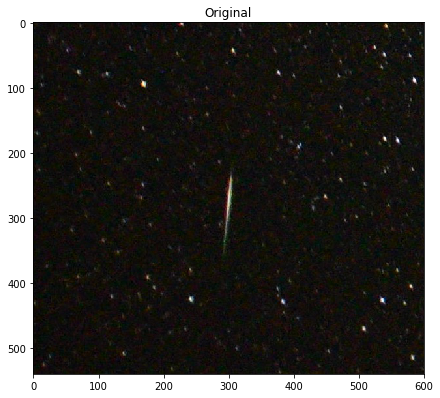

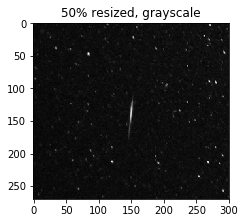

In [1]:
%matplotlib inline
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K
from PIL import Image, ImageDraw
from workshop import *

img = Image.open('assets/data_prep_example.jpg')

# Resize the new image to 50% of the original
img_new = img.resize((int(img.width * 0.5), int(img.height * 0.5)), Image.ANTIALIAS)

# Convert to grayscale
img_new = np.array(img_new.convert('L'))

# Plot the original and transformed image
# Original
fig = plt.figure(figsize=(7, 7))
fig.gca().title.set_text('Original')
fig.gca().imshow(img);

# resized, grayscale
fig = plt.figure(figsize=(3.5, 3.5))
fig.gca().title.set_text('50% resized, grayscale')
fig.gca().imshow(img_new, cmap='gray');

### Synthetic data

The dataset does not contain enough meteors to train a robust and accurate machine learning model. The research team simplified the problem to identify any transient objects (streaks) in the images. Transient objects can be meteors, satellites and planes.

Therefore, we experimented with generating a synthetic dataset of transient objects to train our model. We manually identified images of the night sky that contained no streaks and used these as the background to generate our synthetic / fake meteor images.

Let's inspect two background examples.

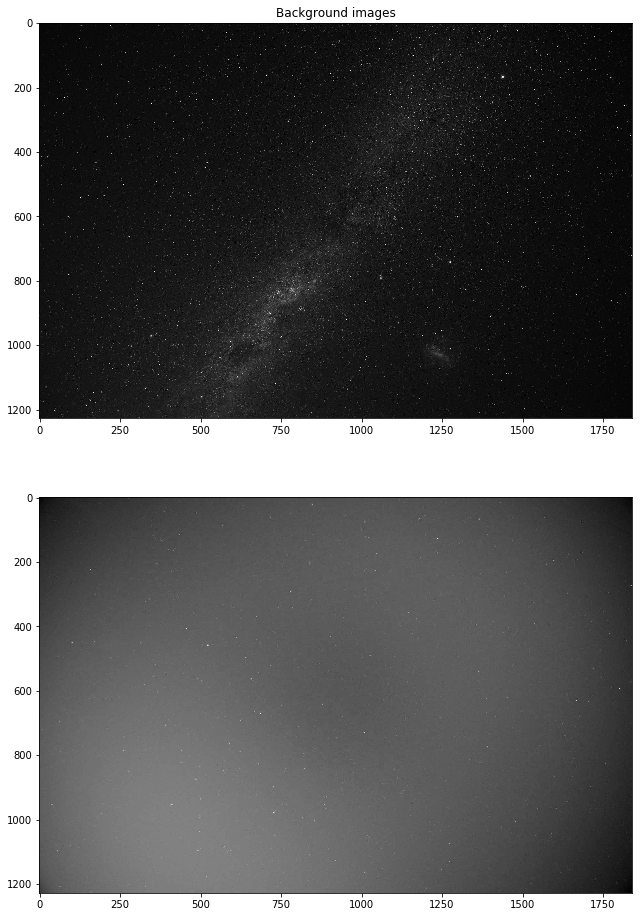

In [2]:
# Plot the original and transformed image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
img1 = Image.open('assets/background1.jpg')
ax1.imshow(np.asarray(img1), cmap='gray');
ax1.set_title('Background images')
img2 = Image.open('assets/background2.jpg')
ax2.imshow(np.asarray(img2), cmap='gray');

Note: the second image is more illuminated than the first with less visible stars. This is because the second image was taken closer to dawn / sunrise. We use 272 different background images to ensure enough variation (different real world conditions) is added to our dataset.

Define functions to create tiled images (200x200 pixel resolution).

In [3]:
# Computes distance between two points in pixels
def dist(A): 
    return(((A[0][0] - A[0][2])**2 + (A[0][1] - A[0][3])**2)**0.5)

def generate_streaks(seed=0):
    np.random.seed(seed)
    tile_w = 200 
    tile_h = 200
    n=10
    images = []

    for __ in range(n):
        bg_rand = np.random.choice([1, 2])    
        img = Image.open('assets/background' + str(bg_rand) + '.jpg')
        width, height = img.size
        marker_x = np.random.randint(0, width - tile_w)
        marker_y = np.random.randint(0, height - tile_h)

        # crop a portion of the full image
        im = img.crop((marker_x, marker_y, marker_x + tile_w, marker_y + tile_h))
        draw = ImageDraw.Draw(im)

        A = [(np.random.rand() * im.size[0], np.random.rand() * im.size[1],
              np.random.rand() * im.size[0], np.random.rand() * im.size[1])]

        # The lines shouldn't be too short or too long
        while dist(A) <= 30 or dist(A) >= 300:
            A = [(np.random.rand() * im.size[0], np.random.rand() * im.size[1],
                  np.random.rand() * im.size[0], np.random.rand() * im.size[1])]

        if dist(A) > 30 and dist(A) < 300: 
            # Brightness should be over certain threshold, 
            # lower the brightness -> harder to train, more resilient
            color_rnd = np.random.uniform(0.8, 1.0)  
            width_rand = np.random.choice([1, 2])
            draw.line([A[0][0], A[0][1], A[0][2], A[0][3]], fill=int(color_rnd * 250), width=width_rand)
            del draw
        
        images.append(im)
        
    plot_streaks(images)

def plot_streaks(images):
    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.imshow(np.asarray(image), cmap='gray')
        ax.axis('off')

Let's look at some of the generated images

In [4]:
interact(generate_streaks, 
         seed=widgets.IntSlider(min=0, max=10, step=1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='seed', max=10), Output()), _dom…

Currently our function only generates image tiles with streaks. Now let's define a more complete function that will generate image with/without streaks and assign the correct label (0 = no streak, 1 = streak) to the image. 

In [5]:
def synthetic_images(batch_size=80, seed=0):
    
    if seed:
        np.random.seed(seed)
    tile_w = 200 
    tile_h = 200

    hdf = h5py.File('meteors.hd5', 'r')
    bg_images = hdf['night_sky'][:]

    while True:
        images = []
        labels = []
        
        for i in range(batch_size):
            bg_rand = np.random.randint(bg_images.shape[0])
            img = Image.fromarray(bg_images[bg_rand])
            width, height = img.size

            marker_x = np.random.randint(0, width - tile_w)
            marker_y = np.random.randint(0, height - tile_h)

            # crop a portion of the full image
            im = img.crop((marker_x, marker_y, marker_x + tile_w, marker_y + tile_h))
            draw = ImageDraw.Draw(im)

            A = [(np.random.rand() * im.size[0], np.random.rand() * im.size[1],
                  np.random.rand() * im.size[0], np.random.rand() * im.size[1])]

            # The lines shouldn't be too short or too long
            while dist(A) <= 30 or dist(A) >= 300:
                A = [(np.random.rand() * im.size[0], np.random.rand() * im.size[1],
                      np.random.rand() * im.size[0], np.random.rand() * im.size[1])]

            label = 0
            # Only draw streaks for half the images
            if (np.random.rand() > 0.5): 
                if dist(A) > 30 and dist(A) < 300: 
                    # Brightness should be over certain threshold, 
                    # lower the brightness -> harder to train, more resilient
                    color_rnd = np.random.uniform(0.8, 1.0)  
                    width_rand = np.random.choice([1, 2])
                    draw.line([A[0][0], A[0][1], A[0][2], A[0][3]], fill=int(color_rnd * 250), width=width_rand)
                    label = 1
                    del draw

            images.append(np.array(im).reshape([tile_w, tile_h, 1]))
            labels.append(label)

        yield np.array(images), np.array(labels)

Label: 0


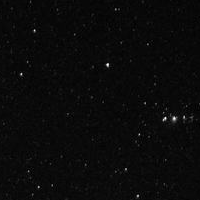

In [11]:
#Visualize images
out = next(synthetic_images(batch_size=1))
print('Label: %d' % (out[1][0]))
Image.fromarray(out[0][0].squeeze())

## 4. Model

Through our experimentation, we designed a CNN model architecture that was able to achieve good classification performance.

In [81]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization
from keras.models import Model
import os

def create_model(seed):
    tf.set_random_seed(seed)
    np.random.seed(seed)

    # Input image tiles are 200 x 200 x 1 images
    inp = Input(shape=(200, 200, 1))

    # 3 sets of convolution + pooling layers, REctified Linear Unit activation (non linear)
    x = Conv2D(8, 3, activation='relu')(inp)
    x = MaxPool2D()(x)
#     x = BatchNormalization()(x)
    x = Conv2D(10, 3, activation='relu')(x)
    x = MaxPool2D()(x)
#     x = BatchNormalization()(x)
    x = Conv2D(12, 3, activation='relu')(x)
    x = MaxPool2D()(x)
#     x = BatchNormalization()(x)
    x = Flatten()(x)

    # 5 fully connected layers
    for __ in range(5):
        x = Dense(5)(x)

    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(optimizer='adagrad', loss='binary_crossentropy')
    
    return model

seed = 1
model = create_model(seed)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 198, 198, 8)       80        
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 97, 97, 10)        730       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 48, 48, 10)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 46, 46, 12)        1092      
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 23, 23, 12)        0         
__________

## 5. Training

Let's train our CNN model using the `fit_generator` method. This makes use of our synthetic_images function that generates our streaks and no streaks images on the fly.

In [82]:
files = sorted(glob.glob('meteors_validation/*/*jpg'))

data = []
labels = []

for index, file in enumerate(files):
    img = Image.open(file)
    data.append(np.array(img))
    if index < 4:
        labels.append(0)
    else:
        labels.append(1)
        
labels = np.array(labels)
data = np.array(data).reshape(len(labels), 200, 200, 1)

In [88]:
# ~2 mins to train 
model = create_model(1)
model.fit_generator(synthetic_images(batch_size=40, seed=0), steps_per_epoch=30, epochs=10, 
                    validation_data=(data, labels))

Epoch 1/30
30/30 [==============================] - 14s 467ms/step - loss: 0.6864 - val_loss: 0.6926
Epoch 2/30
30/30 [==============================] - 11s 356ms/step - loss: 0.2805 - val_loss: 0.7230
Epoch 3/30
30/30 [==============================] - 11s 362ms/step - loss: 0.2168 - val_loss: 0.8111
Epoch 4/30
30/30 [==============================] - 11s 356ms/step - loss: 0.1678 - val_loss: 0.8306
Epoch 5/30
30/30 [==============================] - 11s 368ms/step - loss: 0.1385 - val_loss: 0.5728
Epoch 6/30
30/30 [==============================] - 11s 362ms/step - loss: 0.1315 - val_loss: 0.8803
Epoch 7/30
30/30 [==============================] - 12s 394ms/step - loss: 0.0730 - val_loss: 0.8911
Epoch 8/30
30/30 [==============================] - 11s 369ms/step - loss: 0.0924 - val_loss: 0.8980
Epoch 9/30
30/30 [==============================] - 11s 353ms/step - loss: 0.0778 - val_loss: 1.8171
Epoch 10/30
30/30 [==============================] - 12s 399ms/step - loss: 0.0661 - val_lo

## 6. Validation

Run the trained model on unseen validation images

In [89]:
# TODO: show some samples of background / meteors
import glob
@interact
def showimage(filename=sorted(glob.glob('meteors_validation/*/*jpg'))):
    img=Image.open(filename)
    img_arr=np.array(img)
    print ("Prediction: ", np.round(model.predict(img_arr.reshape([1,
                                                                  img_arr.shape[0],
                                                                  img_arr.shape[1],1]))))
    return img

interactive(children=(Dropdown(description='filename', options=('meteors_validation/0/1_0.jpg', 'meteors_valid…

We've only evaluated the model on a sample of 8 validation images. How well does our model perform on the validation and test datasets? In our real experimentation, we needed to take a more involved  approach to train an accurate model:

<p><center><img src='assets/training.png'></center></p>

Initially we generated a dataset with bright streaks and progressively made them fainter and fainter. 

<p><center><img src='assets/results.png'></center></p>

## 7. Visualisation

Let's visualise the convolutional layers of the trained model. This allows us to check our model to determine what pixels excite / activate our convolution filters and allows us to debug errors / difficult images (e.g. detecting very faint meteors on well-lit images of the night sky).





In [241]:
# Visualise the layer
def vis_layer(v, ix, iy, ch, cy, cx, p=0) :
    v = np.reshape(v, (iy, ix, ch))
    ix += 2
    iy += 2
    npad = ((1, 1), (1, 1), (0, 0))
    v = np.pad(v, pad_width=npad, mode='constant', constant_values=p)
    v = np.reshape(v, (iy, ix, cy, cx)) 
    v = np.transpose(v, (2,0,3,1)) #cy,iy,cx,ix
    v = np.reshape(v, (cy*iy, cx*ix))
    return v

def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output])
    activations = get_activations([X_batch, 0])
    return activations

def plot_layer(feature_map, width, height, channels, rows, columns):
    v  = vis_layer(feature_map, width, height, channels, rows, columns)
    plt.figure(figsize = (16, 16))
    plt.imshow(v, interpolation='nearest', cmap='gray')    
    plt.axis('off');
    
def plot_activations(image):
    img = Image.open(image)
    img = np.array(img).reshape(1, 200, 200, 1)

    conv_layers = [i for i, layer in enumerate(model.layers) if type(layer) == Conv2D]
    print('Conv layers 1-%d' % (len(conv_layers)))
    
    for index, conv in enumerate(conv_layers):
        feature_map = get_activations(model, conv, img)
        image_shape = feature_map[0].shape[1]
        n_filters = model.layers[conv].get_weights()[0].shape[3]
        plot_layer(feature_map, image_shape, image_shape, n_filters, 2, int(n_filters / 2))

files = sorted(glob.glob('meteors_validation/1/*jpg'))
_ = interact(plot_activations, image=files)

interactive(children=(Dropdown(description='image', options=('meteors_validation/1/1_1.jpg', 'meteors_validati…

This visualisation gives us an insight to what the model is paying attention to. Ideally, we want the filters to activate for the streaks (i.e. pixels) and ignore / remove (despeckle) the stars from the image background.

## 8. Test dataset

Now we have trained an accurate model, we need to script a workflow that takes the original images and generate the detections. This process is depicted below:

<p><center><img src='assets/detection.png'></center></p>

The workflow scripts are quite involved and are not presented here. However, here is an example of the visualised detections for a given image.

<p><center><img src='assets/test.jpg'></center></p>

### Download data

Andrew to download meteors.md5 file from us before he leaves

In [ ]:
#Download and uncompress the dataset. 
#Does nothing if the file already exists
# Download("https://cloudstor.aarnet.edu.au/plus/s/EubVHMQ1lq7zOfD/download","workshop.tar.gz")


## 9. Conclusion

Andrew to wrap up about what was covered in the tutorial